# Install SAM

In [ ]:
!git clone https://github.com/davda54/sam
!cp sam/sam.py sam.py

Cloning into 'sam'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 175 (delta 87), reused 62 (delta 25), pack-reused 0
Receiving objects: 100% (175/175), 646.62 KiB | 6.10 MiB/s, done.
Resolving deltas: 100% (87/87), done.


# Install loss_landscapes

In [ ]:
!pip install loss-landscapes

     |████████████████████████████████| 72 kB 396 kB/s 


In [ ]:
import loss_landscapes
from loss_landscapes.model_interface.model_parameters import ModelParameters

#https://github.com/marcellodebernardi/loss-landscapes/issues/1

def rand_u_like(example_vector: ModelParameters) -> ModelParameters:
    """
    Create a new ModelParameters object of size and shape compatible with the given
    example vector, such that the values in the ModelParameter are uniformly distributed
    in the range [0,1].
    :param example_vector: defines by example the size and shape the new vector will have
    :return: new vector with uniformly distributed values
    """
    new_vector = []

    for param in example_vector:
        new_vector.append(torch.rand(size=param.size(), dtype=example_vector[0].dtype).to(param.device))

    return ModelParameters(new_vector)


def rand_n_like(example_vector: ModelParameters) -> ModelParameters:
    """
    Create a new ModelParameters object of size and shape compatible with the given
    example vector, such that the values in the ModelParameter are normally distributed
    as N(0,1).
    :param example_vector: defines by example the size and shape the new vector will have
    :return: new vector with normally distributed values
    """
    new_vector = []

    for param in example_vector:
        new_vector.append(torch.randn(size=param.size(), dtype=example_vector[0].dtype).to(param.device))

    return ModelParameters(new_vector)

loss_landscapes.model_interface.model_parameters.rand_u_like = rand_u_like
loss_landscapes.model_interface.model_parameters.rand_n_like = rand_n_like
loss_landscapes.main.rand_u_like = rand_u_like
loss_landscapes.main.rand_n_like = rand_n_like

In [ ]:
import copy
from loss_landscapes.metrics.sl_metrics import Loss
from loss_landscapes import random_plane, point

def show_loss_surface(model, steps=40):
    model_copy = copy.deepcopy(model)
    x, y = preloaded_train[0]
    metric = Loss(loss_function, x, y)
    plane = random_plane(model_copy, metric, 0.2, deepcopy_model=True, steps=steps)
    loss_val = point(model_copy, metric)

    fig = plt.figure(figsize=(12, 7))
    ax = plt.axes(projection='3d')
    X = np.array([[j for j in range(steps)] for i in range(steps)])
    Y = np.array([[i for _ in range(steps)] for i in range(steps)])
    ax.view_init(40, 45)
    ax.plot_surface(X, Y, plane, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.85)
    ax.plot([steps / 2], [steps / 2], [loss_val], marker='o', markersize=15, zorder=100, label='found optimum')
    ax.set_title('Surface Plot of Loss Landscape')
    ax.legend()
    fig.show()

# Training utils

In [ ]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import numpy as np
from tqdm import tqdm


def train_epoch(model, optimizer, train_loader):
    loss_log, acc_log = [], []
    model.train()
    for data, target in tqdm(train_loader, desc='Training', position=0, leave=True):
        with torch.cuda.amp.autocast(False):

            optimizer.zero_grad()
            output = model(data)
            
            pred = torch.max(output, 1)[1]
            acc = (pred == target).float().mean().item()
            acc_log.append(acc)
            
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            loss = loss.item()
            loss_log.append(loss)
    return loss_log, acc_log

def test(model, test_loader):
    loss_log, acc_log = [], []
    model.eval()
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            for data, target in tqdm(test_loader, desc='Testing', position=0, leave=True):

                output = model(data)
                loss = loss_function(output, target)
                
                pred = torch.max(output, 1)[1]
                acc = (pred == target).float().mean().item()
                acc_log.append(acc)
                
                loss = loss.item()
                loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs, train_loader, test_loader):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, train_loader)

        val_loss, val_acc = test(model, test_loader)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(preloaded_train)
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')
        print("Epoch {} error = {:.2%}".format(epoch, 1 - val_acc_log[-1][1]))
            
    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))


def train_epoch_sam(model, optimizer, train_loader):
    loss_log, acc_log = [], []
    model.train()
    for data, target in tqdm(train_loader, desc='Training', position=0, leave=True):
        with torch.cuda.amp.autocast(False):
            def closure():
                loss = loss_function(model(data), target)
                loss.backward()
                return loss

            optimizer.zero_grad()
            output = model(data)
            
            pred = torch.max(output, 1)[1]
            acc = (pred == target).float().mean().item()
            acc_log.append(acc)
            
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step(closure)

            loss = loss.item()
            loss_log.append(loss)
    return loss_log, acc_log
    
def train_sam(model, opt, n_epochs, train_loader, test_loader):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch_sam(model, opt, train_loader)

        val_loss, val_acc = test(model, test_loader)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(preloaded_train)
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')
        print("Epoch {} error = {:.2%}".format(epoch, 1 - val_acc_log[-1][1]))
            
    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))

class GaussianNoise:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        return sample + torch.randn(sample.size()) * self.std + self.mean


class LabelNoise:
    def __init__(self, p, max_label=10):
        self.p = p
        self.max_label = max_label

    def __call__(self, sample):
        if np.random.rand(1) < self.p:
            return np.random.randint(0, self.max_label)
        return sample

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compare on noised MNIST

#### Basic optimizer

In [ ]:
train_mnist = torchvision.datasets.MNIST('mnist', download=True, train=True, transform=T.Compose([T.ToTensor(), T.Normalize(0.5, 0.5)]),
                                                                                                  target_transform=LabelNoise(0.8))
test_mnist = torchvision.datasets.MNIST('mnist', download=True, train=False, transform=T.Compose([T.ToTensor(), T.Normalize(0.5, 0.5)]))

train_mnist_loader = DataLoader(train_mnist, batch_size=512, shuffle=True)
test_mnist_loader = DataLoader(test_mnist, batch_size=512, shuffle=True)

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 32),
    nn.ReLU(),
    nn.Linear(32, 10),
    nn.Softmax(dim=1)
).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
preloaded_train = [(batch[0].to(device), batch[1].to(device)) for batch in tqdm(train_mnist_loader, desc='Preloading train', position=0, leave=True)]
preloaded_test = [(batch[0].to(device), batch[1].to(device)) for batch in tqdm(test_mnist_loader, desc='Preloading test', position=0, leave=True)]

Preloading test: 100%|██████████| 20/20 [00:01<00:00, 14.37it/s]


In [ ]:
loss_function = nn.CrossEntropyLoss()

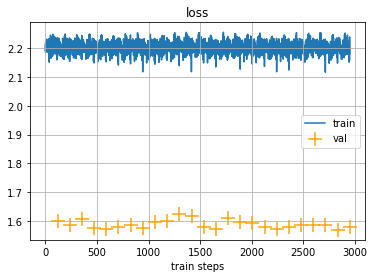

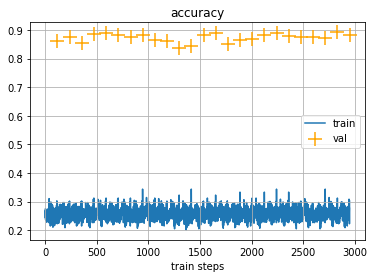

Epoch 24 error = 11.81%
Final error: 11.81%


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=10, bias=True)
  (4): Softmax(dim=1)
)

In [ ]:
train(model, optimizer, 25, preloaded_train, preloaded_test)
model.eval()

In [ ]:
acc_log

[(118, 0.8597139239311218),
 (236, 0.8744944840669632),
 (354, 0.8553825825452804),
 (472, 0.8870404422283172),
 (590, 0.8885914534330368),
 (708, 0.8819623172283173),
 (826, 0.8753446698188782),
 (944, 0.8838579952716827),
 (1062, 0.8649758726358414),
 (1180, 0.8608111202716827),
 (1298, 0.8379710465669632),
 (1416, 0.842503446340561),
 (1534, 0.8832433372735977),
 (1652, 0.8894933372735977),
 (1770, 0.8523322612047195),
 (1888, 0.8655158549547195),
 (2006, 0.86865234375),
 (2124, 0.882421875),
 (2242, 0.8880170047283172),
 (2360, 0.8802562028169632),
 (2478, 0.8756606161594391),
 (2596, 0.8755514711141587),
 (2714, 0.8735753685235977),
 (2832, 0.8920209109783173),
 (2950, 0.8819393396377564)]

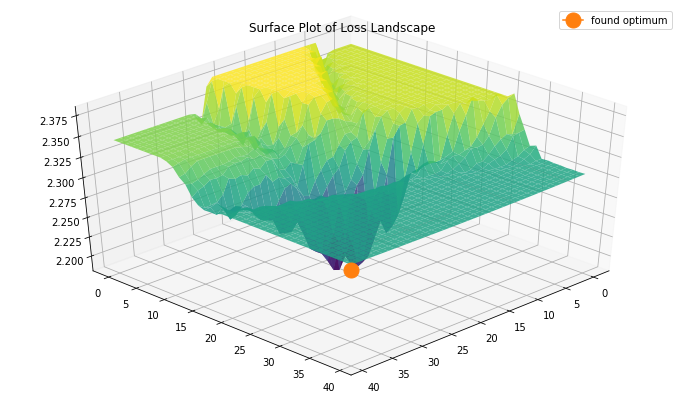

In [ ]:
show_loss_surface(model)

#### SAM optimizer

In [ ]:
from sam import SAM

In [ ]:
sam_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 32),
    nn.ReLU(),
    nn.Linear(32, 10),
    nn.Softmax(dim=1)
).to(device)

In [ ]:
sam_optimizer = SAM(sam_model.parameters(), torch.optim.Adam, lr=0.01)

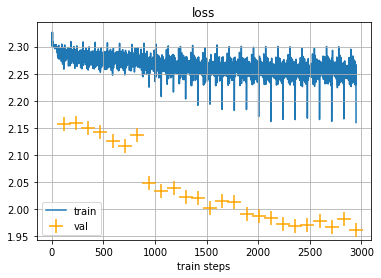

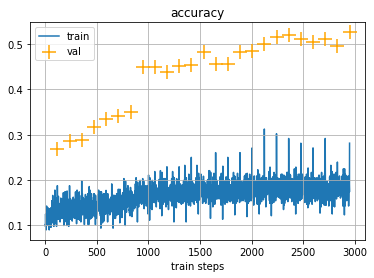

Epoch 24 error = 47.39%
Final error: 47.39%


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=10, bias=True)
  (4): Softmax(dim=1)
)

In [ ]:
train_sam(sam_model, sam_optimizer, 25, preloaded_train, preloaded_test)
model.eval()

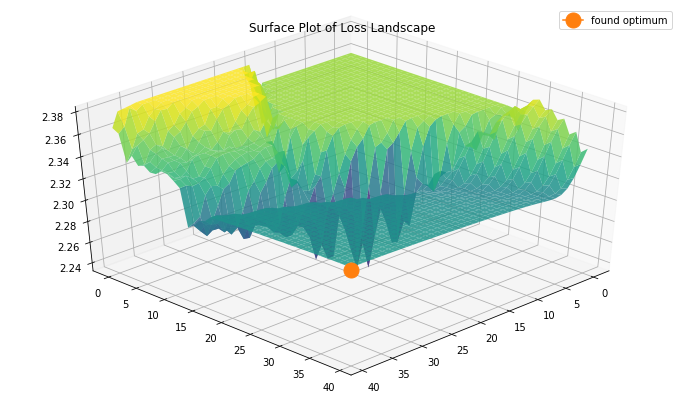

In [ ]:
show_loss_surface(sam_model)

# Compare on noised CIFAR-10

In [ ]:
train_cifar = torchvision.datasets.CIFAR10('cifar', download=True, train=True, transform=T.Compose([T.ToTensor(), T.Normalize(0.5, 0.5)]),
                                                                                                  target_transform=LabelNoise(0.5))
test_cifar = torchvision.datasets.CIFAR10('cifar', download=True, train=False, transform=T.Compose([T.ToTensor(), T.Normalize(0.5, 0.5)]))

train_cifar_loader = DataLoader(train_cifar, batch_size=512, shuffle=True)
test_cifar_loader = DataLoader(test_cifar, batch_size=512, shuffle=True)

model = nn.Sequential(
    nn.Conv2d(3, 8, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.Conv2d(8, 16, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.Flatten(),
    nn.Linear(16 * 8 * 8, 10),
    nn.Softmax(dim=-1)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from tqdm import tqdm

preloaded_train = [(batch[0].to(device), batch[1].to(device)) for batch in tqdm(train_cifar_loader, desc='Preloading train', position=0, leave=True)]
preloaded_test = [(batch[0].to(device), batch[1].to(device)) for batch in tqdm(test_cifar_loader, desc='Preloading test', position=0, leave=True)]

Preloading test: 100%|██████████| 20/20 [00:01<00:00, 11.24it/s]


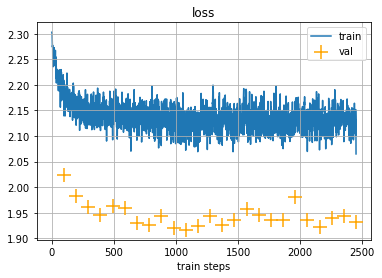

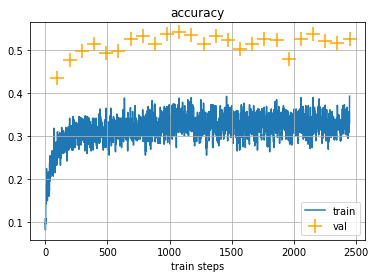

Epoch 24 error = 47.32%
Final error: 47.32%


Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1024, out_features=10, bias=True)
  (8): Softmax(dim=-1)
)

In [ ]:
train(model, optimizer, 25, preloaded_train, preloaded_test)
model.eval()

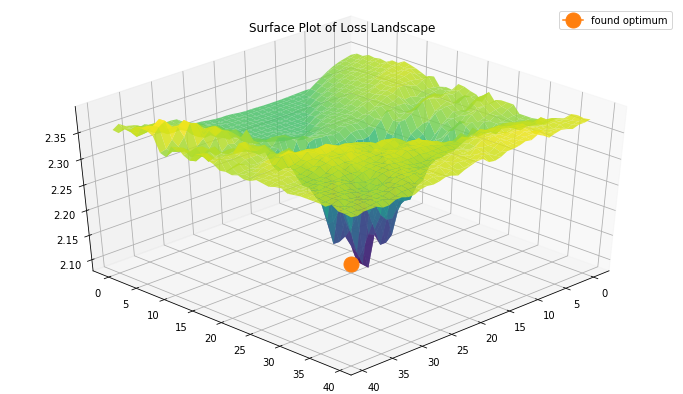

In [ ]:
show_loss_surface(model)

In [ ]:
sam_model = nn.Sequential(
    nn.Conv2d(3, 8, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.Conv2d(8, 16, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.Flatten(),
    nn.Linear(16 * 8 * 8, 10),
    nn.Softmax(dim=-1)
).to(device)
sam_optimizer = SAM(sam_model.parameters(), type(optimizer), lr=0.01)

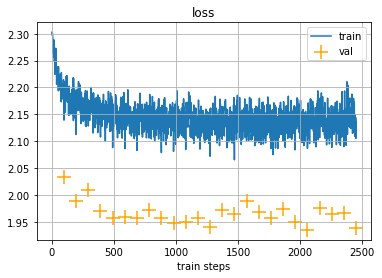

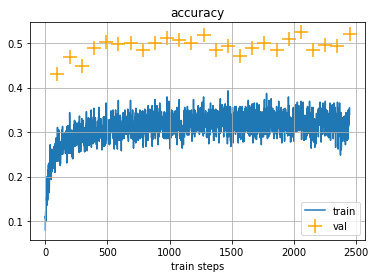

Epoch 24 error = 47.87%
Final error: 47.87%


Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1024, out_features=10, bias=True)
  (8): Softmax(dim=-1)
)

In [ ]:
train_sam(sam_model, sam_optimizer, 25, preloaded_train, preloaded_test)
model.eval()

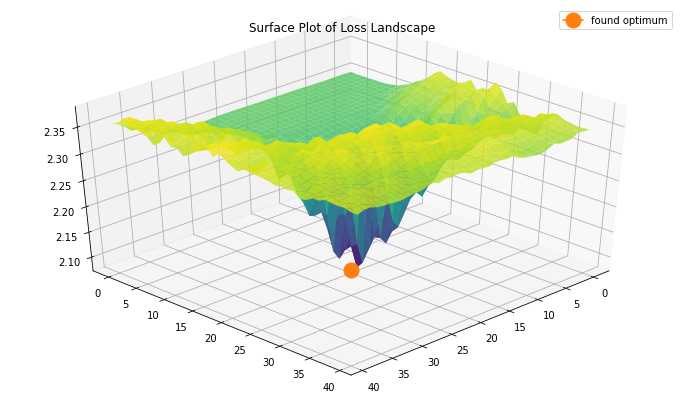

In [ ]:
show_loss_surface(sam_model)

# Compare on function with 2d domain

SAM-Adagrad optimization compared to pure Adagrad on some functions from https://en.wikipedia.org/wiki/Test_functions_for_optimization

In [ ]:
#@title 2D optimization and visualization code
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sam import SAM

def get_2d_optimization_path(loss_fn, optimizer_cls, lr, start_point, steps=10, optimizer_kwargs={}):
    params = torch.tensor(start_point, dtype=float)
    params.requires_grad = True
    optimizer = optimizer_cls([params], lr=lr, **optimizer_kwargs)

    history = [(*start_point, loss_fn(params[0], params[1]))]
    sam_history = []

    for _ in range(steps):
        def closure():
            loss = loss_fn(params[0], params[1])
            loss.backward()
            return loss
        
        loss = loss_fn(params[0], params[1])
        loss.backward()
        if optimizer_cls is SAM:
            loss = loss_fn(params[0], params[1])
            loss.backward()
            optimizer.first_step(zero_grad=True)
            sam_history.append((params[0].item(), params[1].item(), loss))
            loss = loss_fn(params[0], params[1])
            loss.backward()
            optimizer.second_step(zero_grad=True)
        else:
            optimizer.step()
            optimizer.zero_grad()
        history.append((params[0].item(), params[1].item(), loss))

    if sam_history:
        return np.array(history), np.array(sam_history)
    else:
        return np.array(history)

def plot_2d_optimization(loss_fn, optimizer_history, bounds, center, sam_history=None, opt_name='Adagrad'):
    x = np.linspace(center[0] + bounds[0], center[0] + bounds[1], 500)
    y = np.linspace(center[1] + bounds[0], center[1] + bounds[1], 500)
    x, y = np.meshgrid(x, y)

    matplotlib.rcParams.update({'font.size': 16})

    fig = plt.figure(figsize=(15, 7))
    fig.suptitle(f'Loss Landscape and {opt_name} descent trajectory')
    axs = [fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2)]
    axs[0].view_init(40, 45)
    axs[0].plot_surface(x, y, loss_fn(x, y), cmap='viridis', edgecolor='none', alpha=0.85)
    axs[0].plot(optimizer_history[:1, 0], optimizer_history[:1, 1], optimizer_history[:1, 2], zorder=101, markersize=10, marker='x', color='red', label='starting point')
    axs[0].plot(optimizer_history[:, 0], optimizer_history[:, 1], optimizer_history[:, 2], zorder=100, markersize=5, marker='o', label='descent trajectory')
    if sam_history is not None:
        axs[0].plot(sam_history[:, 0], sam_history[:, 1], sam_history[:, 2], zorder=99, markersize=5, color='green', marker='v', label='weights + epsilon SAM step')
    axs[0].legend()

    axs[1].contour(x, y, loss_fn(x, y), cmap='viridis')
    axs[1].plot(optimizer_history[:1, 0], optimizer_history[:1, 1], zorder=101, markersize=10, marker='x', color='red', label='starting point')
    axs[1].plot(optimizer_history[:, 0], optimizer_history[:, 1], zorder=100, markersize=5, color='orange', marker='o', label='descent trajectory')
    if sam_history is not None:
        axs[1].plot(sam_history[:, 0], sam_history[:, 1], zorder=99, markersize=5, color='green', marker='v', label='weights + epsilon SAM step')
    axs[1].legend()

    fig.show()

## Sphere

In [ ]:
def sphere_function(x, y):
    return x ** 2 + y ** 2

In [ ]:
START_POINT = [20, -20]

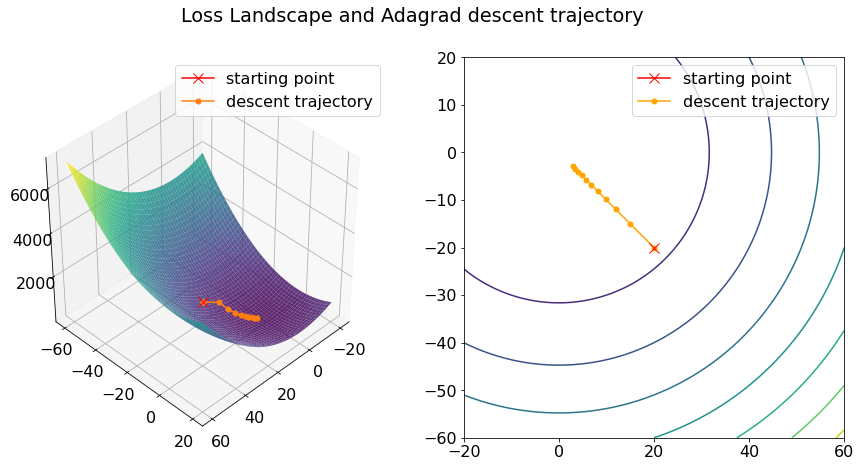

In [ ]:
history = get_2d_optimization_path(sphere_function, torch.optim.Adagrad, 5, START_POINT, steps=10)
plot_2d_optimization(sphere_function, history, (-40, 40), START_POINT)

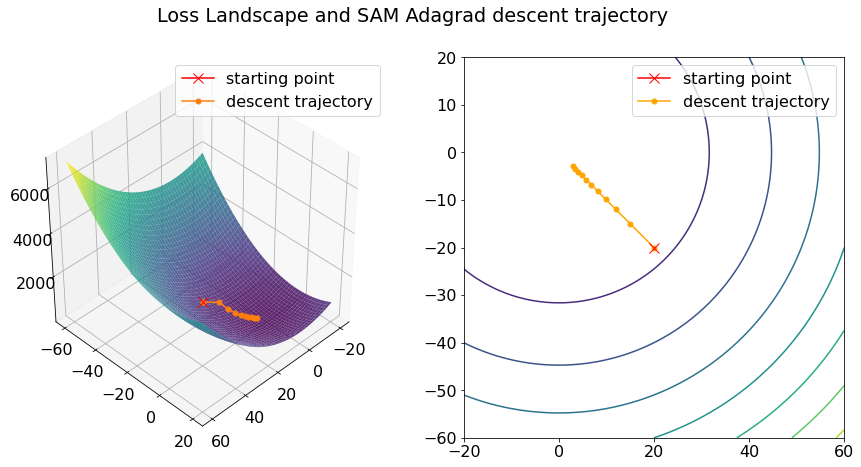

In [ ]:
sam_history = get_2d_optimization_path(sphere_function, SAM, 5, START_POINT, steps=10, optimizer_kwargs={'base_optimizer': torch.optim.Adagrad, 'rho': 1})
plot_2d_optimization(sphere_function, history, (-40, 40), START_POINT, opt_name='SAM Adagrad')

## Easom

In [ ]:
def easom(x, y):
    if isinstance(x, np.ndarray):
        return -np.cos(x) * np.cos(y) * np.exp(-((x - np.pi) ** 2 + (y - np.pi) ** 2))
    return -torch.cos(x) * torch.cos(y) * torch.exp(-((x - np.pi) ** 2 + (y - np.pi) ** 2))

In [ ]:
START_POINT = [np.pi - 1.3, np.pi - 1.3]

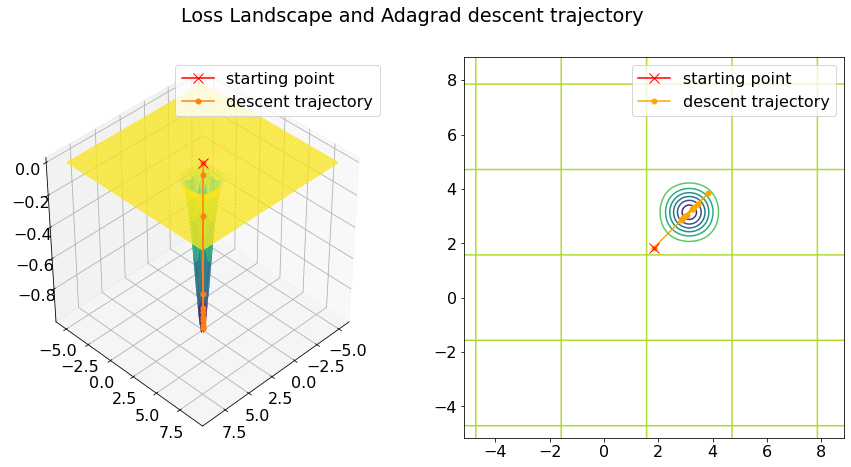

In [ ]:
history = get_2d_optimization_path(easom, torch.optim.Adagrad, 1, START_POINT, steps=10)
plot_2d_optimization(easom, history, (-7, 7), START_POINT)

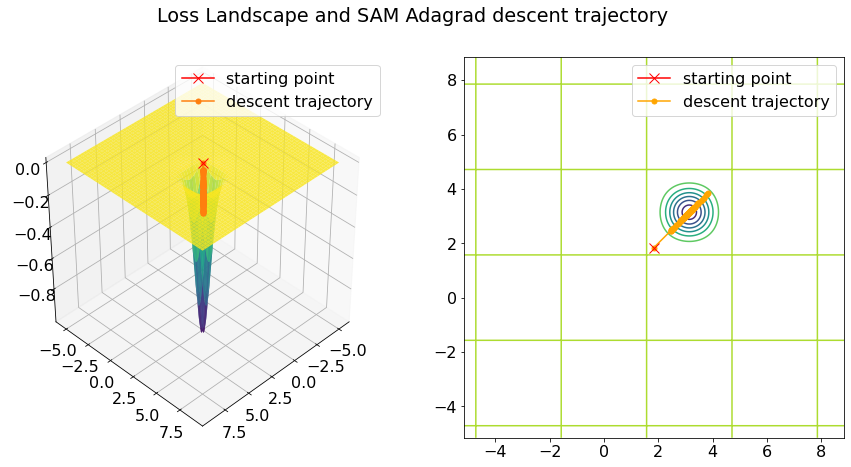

In [ ]:
history, sam_history = get_2d_optimization_path(easom, SAM, 1, START_POINT, steps=100, optimizer_kwargs={'base_optimizer': torch.optim.Adagrad, 'rho': 1})
plot_2d_optimization(easom, history, (-7, 7), START_POINT, opt_name='SAM Adagrad')

## Eggholder

In [ ]:
def eggholder(x, y):
    if isinstance(x, np.ndarray):
        return -(y + 47) * np.sin(np.sqrt(np.abs(x / 2 + y + 47))) - x * np.sin(np.sqrt(np.abs(x - y - 47)))
    return -(y + 47) * torch.sin(torch.sqrt(torch.abs(x / 2 + y + 47))) - x * torch.sin(torch.sqrt(torch.abs(x - y - 47)))

In [ ]:
START_POINT = [-255, -304]

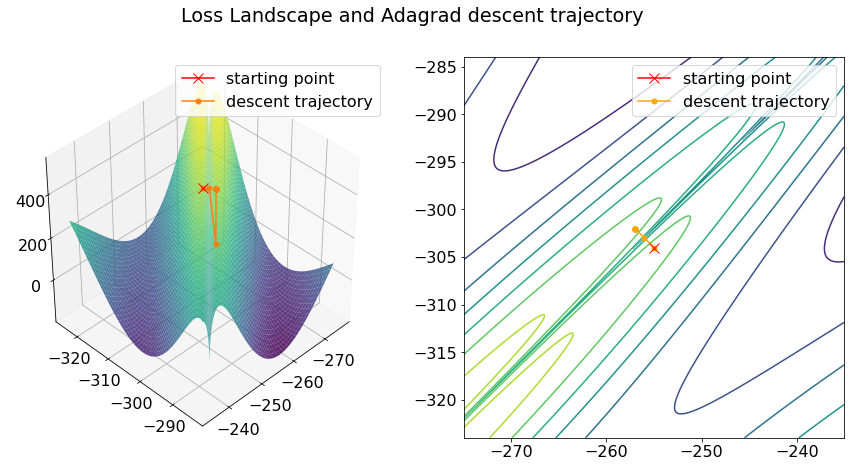

In [ ]:
history = get_2d_optimization_path(eggholder, torch.optim.Adagrad, 1, START_POINT, steps=10)
plot_2d_optimization(eggholder, history, (-20, 20), START_POINT)

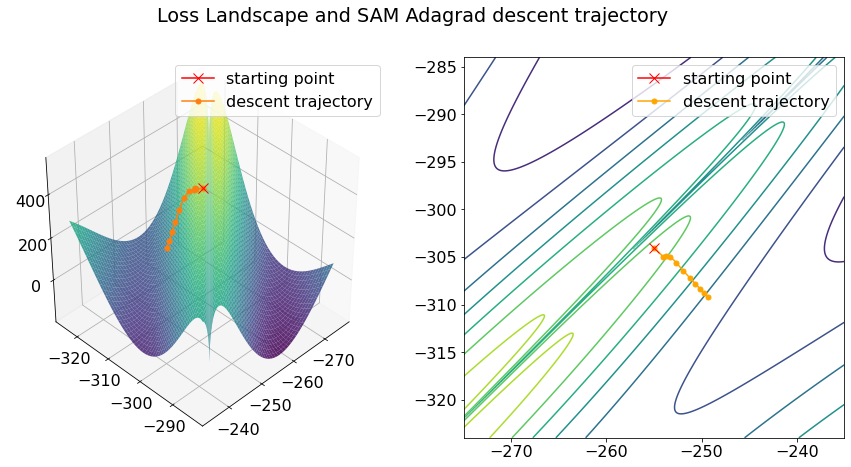

In [ ]:
history, sam_history = get_2d_optimization_path(eggholder, SAM, 1, START_POINT, steps=10, optimizer_kwargs={'base_optimizer': torch.optim.Adagrad, 'rho': 1})
plot_2d_optimization(eggholder, history, (-20, 20), START_POINT, opt_name='SAM Adagrad')

## Restrigin

In [ ]:
def restrigin(x, y):
    if isinstance(x, np.ndarray):
        return 20 + (x**2 - 10 * np.cos(2 * np.pi * x)) + (y**2 - 10 * np.cos(2 * np.pi * y))
    return 20 + (x**2 - 10 * torch.cos(2 * np.pi * x)) + (y**2 - 10 * torch.cos(2 * np.pi * y))

In [ ]:
START_POINT = [-20, 4]

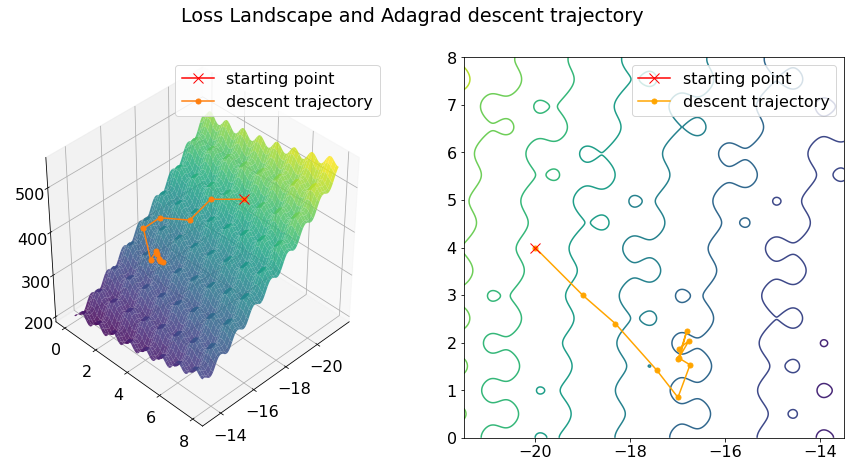

In [ ]:
history = get_2d_optimization_path(restrigin, torch.optim.Adagrad, 1, START_POINT, steps=10)
plot_2d_optimization(restrigin, history, (-4, 4), (START_POINT[0] + 2.5, START_POINT[1]))

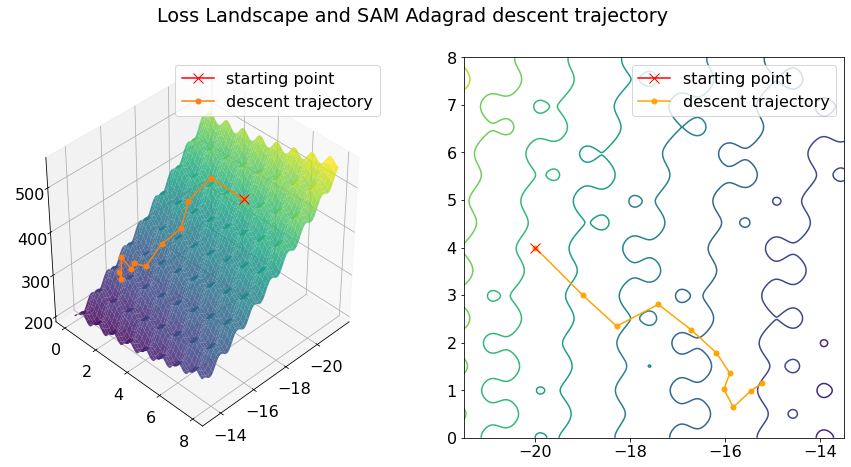

In [ ]:
history, sam_history = get_2d_optimization_path(restrigin, SAM, 1, START_POINT, steps=10, optimizer_kwargs={'base_optimizer': torch.optim.Adagrad, 'rho': 1})
plot_2d_optimization(restrigin, history, (-4, 4), (START_POINT[0] + 2.5, START_POINT[1]), opt_name='SAM Adagrad')

# Plot SAM loss

In [ ]:
def get_sam_loss(loss_fn, rho):
    def f(x, y):
        point = torch.tensor([x, y], dtype=float)
        point.requires_grad = True
        sam = SAM([point], torch.optim.SGD, lr=1, rho=rho)

        loss = loss_fn(point[0], point[1])
        loss.backward()
        sam.first_step()
        return loss_fn(point[0], point[1]).item()
    return f

In [ ]:
def plot_func_surface(func, bounds_x=[-5, 5], bounds_y=[-5, 5]):
    matplotlib.rcParams.update({'font.size': 16})

    x = np.linspace(bounds_x[0], bounds_x[1], 300)
    y = np.linspace(bounds_y[0], bounds_y[1], 300)
    x, y = np.meshgrid(x, y)
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_surface(x, y, func(x, y), cmap='viridis', edgecolor='none')
    plt.show()

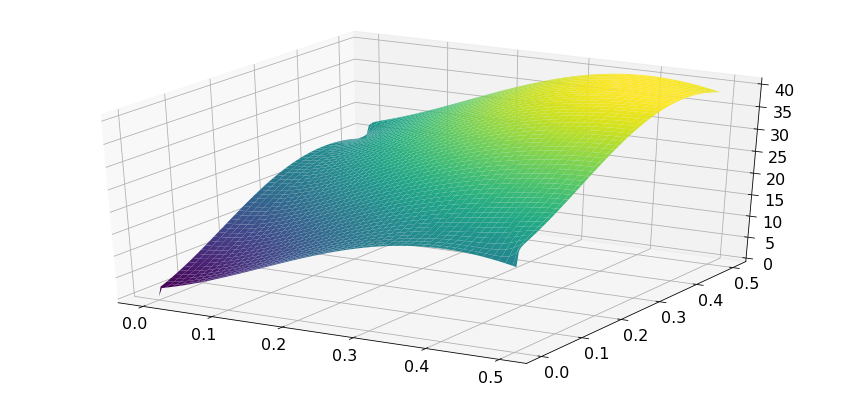

In [ ]:
plot_func_surface(np.vectorize(get_sam_loss(restrigin, rho=0.1)), bounds_x=[0, 0.5], bounds_y=[0, 0.5])

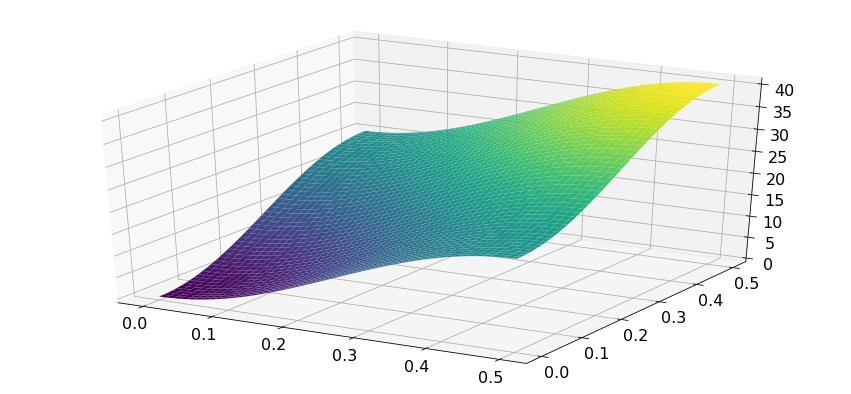

In [ ]:
plot_func_surface(restrigin, bounds_x=[0, 0.5], bounds_y=[0, 0.5])

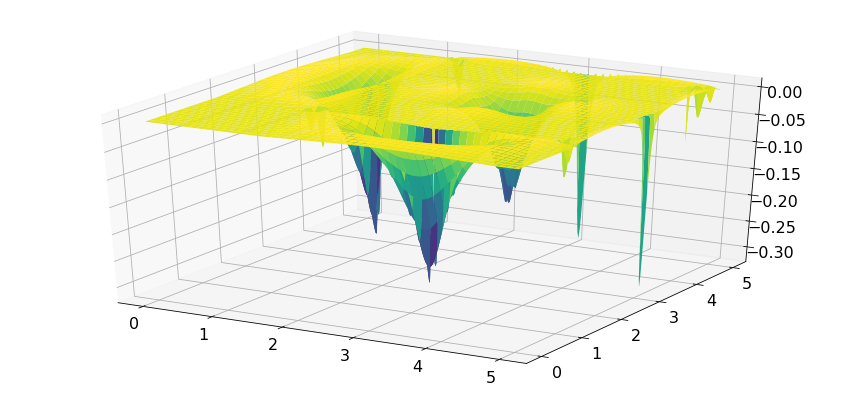

In [ ]:
plot_func_surface(np.vectorize(get_sam_loss(easom, rho=1)), bounds_x=[0, 5], bounds_y=[0, 5])

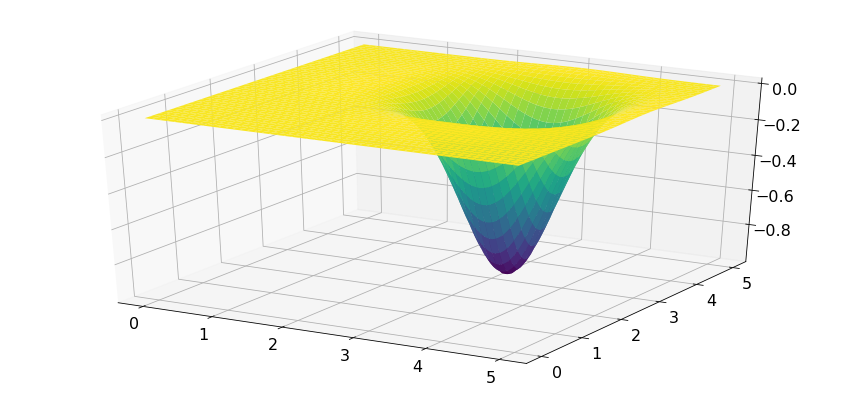

In [ ]:
plot_func_surface(easom, bounds_x=[0, 5], bounds_y=[0, 5])